Airfoils in use for vertical-axis wind turbines (VAWT) see rotating flow and are effectively pitching at high rates.
For different pitching rates, or chord to flow-radius ratios c/R, an airfoil can be translated to another airfoil with a different camber that should exhibit the same behavior as the pitching airfoil but in non-rotating flow.
This effect is known as *virtual camber*.

Establishing wind tunnel tests with pitching airfoils or in rotating flow with the aim of measuring lift and drag is quite difficult, and as far as the author knows has not been realized.
To validate the predictions we turn to two variants:

1. Compare the results to other inviscid methods
2. Compare the results to a study on the effect using RANS simulations of a single-blade VAWT and some regular wind tunnel data of *virtually cambered* airfoils


## 1. Pitching NACA 0015
In [2] a method to compute pressure distributions on rotating airfoils in the context of VAWT is described.
The pressure distributions and the lift slopes calculated here are compared to those given in [2].
The datapoints of the pressure distributions were digitized, but the scans are quite distorted and the simple linear scaling of the axes and manual sampling of the points is not perfect.
Interestingly, the best fit does not occur at zero curvature.
In fact, the lift slope between the two inviscid methods differs systematically and this seems to be counteracted at a c/R of 0.07.

For comparison, the inviscid lift slope without curvature calculated by Javafoil[3] and by another panel method (which seems to have been used for a course at the university of Sydney[4]) is plotted as well.
Javafoil uses a panel method very similar to Viiflow and XFOIL, with linearly varying vortex strengths.
The other method [4] uses piecewise constant source strengths and a single value of vorticity.

In light of these comparisons, the change in pressure distribution and the change lift slope agree quite well.

In [1]:
# Import numpy, plot functions and viiflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load airfoil data, repanel to 200 elements
NACA0015 = vft.repanel_spline(vft.read_selig("NACA0015.dat"),200)

# Shift to rotate at .38 chord
NACA0015[0,:]-=.38

s = vf.setup(itermax=100,silent=True)

# Analyse with rotation
# pitch rate: q_0[rad/s]/v_inf*chord
# Assuming v_inf = q0*R -> q = c/R
crvec = [-0.105,-0.07,0,0.07,0.105]
polar = [] # Save results here
for CDR in crvec:
    AOArange = [-1,6,11] # Make a line, and save pressure at 6°
    s.pitch_rate = CDR;
    s.alpha=AOArange[0]

    # Save results here
    alv = [] 
    clv = []
    cp = []

    # Initialize solution
    (p,bl,x) = vf.init(NACA0015,s)
    
    # Solve for all AOA
    for alpha in AOArange:
        s.alpha = alpha
        [x,flag,_,_,_] = vf.iter(x,bl,p,s)
        
        # Save solution
        alv.append(alpha)
        clv.append(p.CLi) # Save *inviscid* CL from CLi
        
        # Save *inviscid* pressure distribution at 6° for plots below
        if alpha == 6:
            cp = p.cp_inviscid.copy();

    polar.append({'AOA':np.asarray(alv), 'CL':np.array(clv), 'c/R': s.pitch_rate, 'CP':cp})

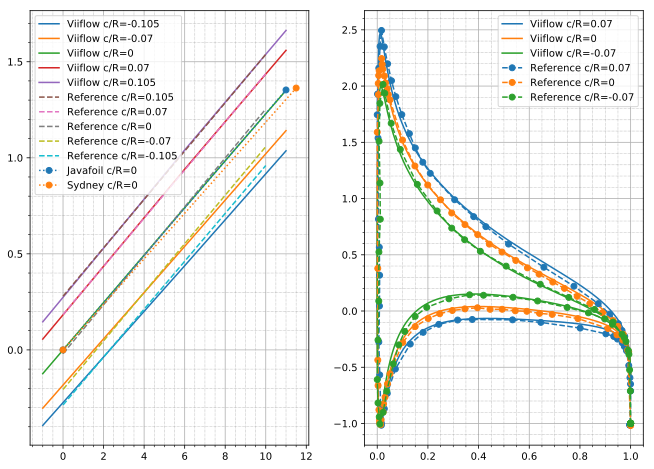

In [2]:
# Make plot big
matplotlib.rcParams['figure.figsize'] = [11, 8]

# 2 Subplots
fig, ax = plt.subplots(1,2)

# First plot: Lift slopes
legend = [] # Save legend entries here

# Plot calculation results
for k in range(len(crvec)):
    ax[0].plot(polar[k]['AOA'],polar[k]['CL'],'-')
    legend.append('Viiflow c/R=%g'%crvec[k])
    
# Plot results from literature (save in csv)
for k in range(5):
    FN25Exp = np.genfromtxt('NACA0015rot.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(FN25Exp.T[0],FN25Exp.T[1],'--')
    legend.append('Reference c/R=%g'%-crvec[k])
    
# Javafoil Result
# Varying vortex strength (like XFOIL & Viiflow)
# https://www.mh-aerotools.de
ax[0].plot([0,11],[0,1.353],':o')
legend.append('Javafoil c/R=0')

# Some software from the University of Sydney
# Found on a website of the University of Cambridge
# Varying source strength, constant vorticity
# http://www-mdp.eng.cam.ac.uk/web/library/enginfo/aerothermal_dvd_only/aero/panel2d/panel2d.html
ax[0].plot([0,11.5],[0,1.363],':o')
legend.append('Sydney c/R=0')
ax[0].legend(legend)

# Add grid
ax[0].grid(1)
ax[0].minorticks_on()
ax[0].grid(which='minor', linestyle=':', linewidth='0.5', color='grey')


# Second Plot: Pressure distributions
legend = []
cmap = plt.get_cmap("tab10") # Use the same color for same c/R

for k in range(3):
    ax[1].plot(p.foils[0].X[0,:]+.38,-polar[3-k]['CP'],'-')
    legend.append('Viiflow c/R=%g'%crvec[3-k])
    
# Plot results from literature
for k in range(3):
    FN25Exp = np.genfromtxt('NACA0015rot.csv',skip_header=1,delimiter=",",usecols=[11+2*k,11+2*k+1])
    maxv = np.max(FN25Exp.T[0])
    minv = np.min(FN25Exp.T[0])
    ax[1].plot((FN25Exp.T[0]-minv)/(maxv-minv),FN25Exp.T[1],'--o',color=cmap(k))
    legend.append('Reference c/R=%g'%crvec[3-k])
ax[1].legend(legend);

ax[1].grid(1)
ax[1].minorticks_on()
ax[1].grid(which='minor', linestyle=':', linewidth='0.5', color='grey')


## 2. Pitching NACA 0018
In [1] the NACA0018 has been analyzed in pitching motion for the effects on VAWT use.
The virtual airfoils from inviscid theory have been calculated for two pitching rates and these have been experimentally evaluated.
**The *experimental* results are therefore the experimental results of transformed airfoils based on inviscid theory in a regular wind tunnel.**
In addition, RANS simulations of a 1-blade VAWT were run with the same c/R ratios and the lift and drag values of the airfoil during operation were estimated.

Below, the airfoil used in the study is calculated with different pitching rates and the lift slopes are compared to the ones in the study.

Important to note is the definition of angle of attack for the RANS simulations.
It is not the geometric angle with respect to the direction of motion.
Instead, the (normalized to -1 to 1) pressure distribution from the RANS simulation is compared to the calculated pressure distribution of the cambered airfoil (normalized to -1 to 1). Where the fit is best, the angle of attack of the cambered airfoil is chosen.
Which, of course, will lead to a better fit with the calculation of the cambered airfoils and makes the comparison of zero-lift angle of attack difficult as well as comparisons of the RANS lift slope with our own calculations here.

The change in maximum lift and lift slope agree well among the methods. 
Beyond that, not much can be interpreted from these results.

In [3]:
# Load airfoil data
NACA0018 = vft.repanel_spline(vft.read_selig("NACA0018.dat"),200)

# Shift to rotate about .5 chord
# Not specifically said, but looking at the transformed airfoils and trying to put a 
# circle somewhere it is clear that the center lies at .5 and not .25
# Which is not what they did with the RANS VAWT simulations, where the airfoil seems to be attached
# at .25.
NACA0018[0,:]-=.5

# Setup
ncrit = 9
RE = 300000
s = vf.setup(Re=RE,Ma=0.0,ncrit=ncrit,itermax=100,silent=True)

# Analyse with rotation
# pitch rate: q_0[rad/s]/v_inf*chord
# Assuming v_inf = q0*R, i.e. no additional airspeed: q = c/R

crvec = [0,0.114,0.25]
polar = []
for CDR in crvec:
    AOArange = np.arange(0,20,.5)
    s.pitch_rate = CDR;
    s.alpha=AOArange[0]

    alv = []
    clv = []
    cdv = []

    # Go up
    (p,bl,x) = vf.init(NACA0018,s)
    for alpha in AOArange:
        s.alpha = alpha
        [x,flag,_,_,_] = vf.iter(x,bl,p,s)
        if flag:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD)
    
    # Go down
    s.alpha=-AOArange[1]
    (p,bl,x) = vf.init(NACA0018,s)
    for alpha in AOArange[1::]:
        s.alpha = -alpha
        [x,flag,_,_,_] = vf.iter(x,bl,p,s)
        if flag:
            alv.insert(0,-alpha)
            clv.insert(0,p.CL)
            cdv.insert(0,bl[0].CD)

    polar.append({'AOA':np.asarray(alv), 'CL':np.array(clv), 'CD':np.asarray(cdv), 'c/R': s.pitch_rate})

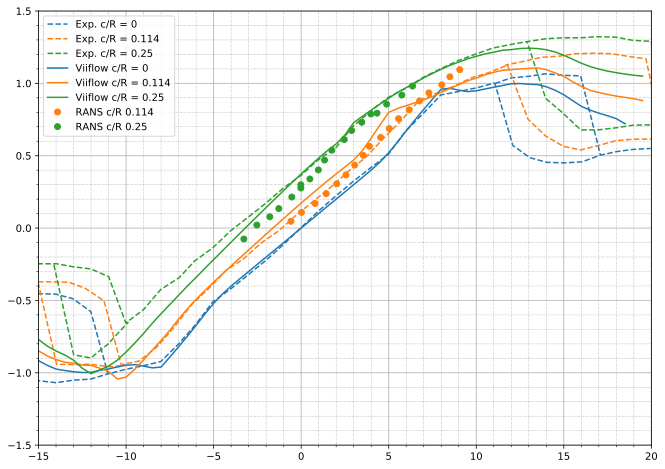

In [4]:
matplotlib.rcParams['figure.figsize'] = [11, 8]
cmap = plt.get_cmap("tab10")
# Load datasets
for k in range(len(crvec)):
    FN25Exp = np.genfromtxt('NACA0018rot.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    plt.plot(FN25Exp.T[0],FN25Exp.T[1],'--',color=cmap(k))

for k in range(len(crvec)):
    plt.plot(polar[k]['AOA'],polar[k]['CL'],'-',color=cmap(k))
    
# Load CFD Datasets
CFD0114 = np.genfromtxt('NACA0018rot.csv',skip_header=1,delimiter=",",usecols=[6,7])
plt.plot(CFD0114.T[0],CFD0114.T[1],'o',color=cmap(1))
CFD025_1 = np.genfromtxt('NACA0018rot.csv',skip_header=1,delimiter=",",usecols=[8,9])
plt.plot(CFD025_1.T[0],CFD025_1.T[1],'o',color=cmap(2))
CFD025_2 = np.genfromtxt('NACA0018rot.csv',skip_header=1,delimiter=",",usecols=[10,11])
plt.plot(CFD025_2.T[0],CFD025_2.T[1],'o',color=cmap(2))

plt.grid(1)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
plt.ylim(-1.5,1.5)
plt.xlim(-15,20)
plt.legend(['Exp. c/R = 0','Exp. c/R = 0.114','Exp. c/R = 0.25','Viiflow c/R = 0','Viiflow c/R = 0.114','Viiflow c/R = 0.25','RANS c/R 0.114','RANS c/R 0.25']);

[1] Rainbird, John M., et al. "On the influence of virtual camber effect on airfoil polars for use in simulations of Darrieus wind turbines." Energy conversion and management 106 (2015): 373-384.

[2] Ghodoosian, Nader. "Calculation of the pressure distribution on a pitching airfoil with application to the Darrieus Rotor." (1983).

[3] https://www.mh-aerotools.de

[4] http://www-mdp.eng.cam.ac.uk/web/library/enginfo/aerothermal_dvd_only/aero/panel2d/panel2d.html